In [106]:
import os
from argparse import ArgumentParser
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from hw3_common import load_data_valid, hw3_dataset, Resnet18
import matplotlib.pyplot as plt
%matplotlib inline

Confusion matrix, without normalization
[[ 223    0  101  161  187   29  130]
 [  15    2   16   25   21    3   10]
 [  97    0  239  117  151   72  118]
 [  77    0   72 1000  109   24  110]
 [ 103    0  137  190  372   19  187]
 [  38    0   86   56   23  398   48]
 [  97    0   77  196  163   40  439]]
Normalized confusion matrix
[[0.27 0.   0.12 0.19 0.23 0.03 0.16]
 [0.16 0.02 0.17 0.27 0.23 0.03 0.11]
 [0.12 0.   0.3  0.15 0.19 0.09 0.15]
 [0.06 0.   0.05 0.72 0.08 0.02 0.08]
 [0.1  0.   0.14 0.19 0.37 0.02 0.19]
 [0.06 0.   0.13 0.09 0.04 0.61 0.07]
 [0.1  0.   0.08 0.19 0.16 0.04 0.43]]


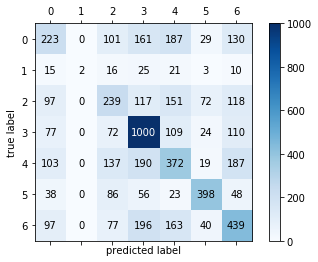

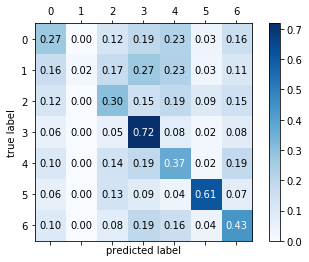

In [103]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.matshow(cm, cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    
    if normalize:
        plt.savefig('img/confusion_matrix_norm.png')
    else:
        plt.savefig('img/confusion_matrix_nonorm.png')
    
    return ax

np.set_printoptions(precision=2)
y_valid = np.load("tmp/y_valid.npy")
y_pred = np.load("tmp/y_pred.npy")
plot_confusion_matrix(y_valid, y_pred, title='Confusion matrix, without normalization')
plot_confusion_matrix(y_valid, y_pred, normalize=True, title='Normalized confusion matrix')

## Use Pretrained Model:

In [116]:
class hw3_dataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transform(img)
        label = self.data[idx][1]
        return img, label

class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.resnet = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])
        self.fc = nn.Linear(512,7)
        # self.fc = nn.Linear(512,128)
        # self.fc2 = nn.Linear(128,7)
    def forward(self, x):
        x = self.resnet(x)
        x = x.view(-1, 1*1*512)
        x = self.fc(x)
        # x = self.fc2(x)

        return x

In [4]:
def load_data(img_path, label_path = None):
    images = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
    if label_path:
        labels = pd.read_csv(label_path)
        labels = labels.iloc[:,1].values.tolist()
    else:
        labels = [0 for x in range(len(images))]
    
    data = list(zip(images, labels))
    if label_path:
        random.seed(42)
        random.shuffle(data)
    
    return data

('data/train_img/20362.jpg', 6)

## Draw saliency map

In [110]:
from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

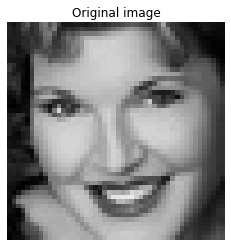

In [132]:
image = load_image("data/test_img/0001.jpg")
plt.imshow(image)
plt.title('Original image')
plt.axis('off');

In [133]:
model = Resnet18()
model.load_state_dict(torch.load('models/hw3_model.pth'))
backprop = Backprop(model)

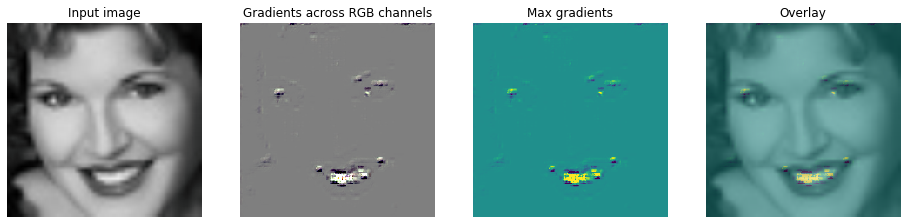

In [134]:
owl = apply_transforms(image)
target_class = 3
backprop.visualize(owl, target_class, guided=True, use_gpu=True)

## Visualize features

In [160]:
from fastai.conv_learner import *
from cv2 import resize

In [161]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [175]:
class FilterVisualizer():
    def __init__(self, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.model = vgg16(pre=True).cuda().eval()
        set_trainable(self.model, False)

    def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
        sz = self.size
        img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255  # generate random image
        activations = SaveFeatures(list(self.model.children())[layer])  # register hook

        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            train_tfms, val_tfms = tfms_from_model(vgg16, sz)
            img_var = V(val_tfms(img)[None], requires_grad=True)  # convert image to Variable that requires grad
#             print(img_var)
            optimizer = torch.optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()
            img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
            self.output = img
            sz = int(self.upscaling_factor * sz)  # calculate new image size
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        self.save(layer, filter)
        activations.close()
        
    def save(self, layer, filter):
        plt.imsave("layer_"+str(layer)+"_filter_"+str(filter)+".jpg", np.clip(self.output, 0, 1))

In [181]:
vgg16

<function fastai.torch_imports.vgg16(pre)>

In [180]:
img = np.uint8(np.random.uniform(150, 180, (48, 48, 3)))/255
tfms_f
val_tfms(img)

NameError: name 'val_tfms' is not defined

In [176]:
layer = 40
filter = 265
FV = FilterVisualizer(size=56, upscaling_steps=12, upscaling_factor=1.2)
FV.visualize(layer, filter, blur=5)

/home/timlee0119/miniconda3/envs/ml2019fall_hw3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [177]:
FV.save(filter, layer)

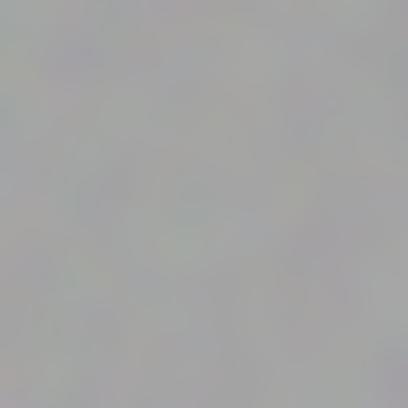

In [178]:
Image.open('layer_40_filter_265.jpg')